This notebook loads a single image taken by a camera in the HPWREN or Alert Wildfire network, breaks it up into 299x299 sub-images, and passes each to the model for classification. If a sub-image is identified as positive for smoke, the image is flagged as containing smoke and the sub-image identified. 

In [1]:
# Setup
from tensorflow import keras
import tensorflow as tf
from keras.models import load_model
import numpy as np
import glob


In [2]:
# load saved model - NOTE: this takes a minute to load (it's 400mb)!
model = keras.models.load_model('Streamline1', compile=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26214528  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 47,076,137
Trainable params: 47,021,609
Non-trainable params: 54,528
_________________________________________________________________


In [93]:
# Takes a full-size image and splits it up into 299x299 subimages with the smallest overlap possible.
# The subimages are all placed in a single folder and are named splitted_1, splitted_2 etc.

import os
from PIL import Image
import cv2 
from IPython.display import display

#path_to_img = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\firesequences\Whittier\whittier_full_no_smoke.jpg'
path_to_img = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\clearfalsepositives\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg'
# deerhorn_full.jpg
#2020 drum_canyon_full_12_56.jpg
#2020 lilac_full_11_25.jpg
# whittier_full_13_40.jpg
# whittier_full_no_smoke.jpg
# 1559167565_+00180_Smoke.jpg
# Margaret\firesequences\lilac_full_11_20.jpg
# Margaret\firesequences\lilac_full_11_22.jpg
# Margaret\firesequences\lilac_full_11_25.jpg

# Output directory for subimages
outputdirectory = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages'

# Delete any previous files from the output directory before adding new splitted images to it
files = glob.glob('C:/Users/mthor/Bootcamp/Wildfire-Detection/Margaret/subimages/*')
for f in files:
    os.remove(f)

# Read in the full image
img = cv2.imread(path_to_img)
img_h, img_w, img_channels = img.shape
split_width = 299
split_height = 299

# Split it up into 299x299 subimages
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points


X_points = start_points(img_w, split_width, 0.01)
Y_points = start_points(img_h, split_height, 0.01)

count = 0
#name = 'splitted'
# Provide the filename prefix
name = 'fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg'
frmt = 'jpg'
  
# Change the current directory 
# to specified directory 
os.chdir(outputdirectory)

for i in Y_points:
    for j in X_points:
        split = img[i:i+split_height, j:j+split_width]
        cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
        count += 1

In [6]:
# Splitted images created by the previous cell are passed to the model for classification
# If a sub-image is identified as positive for smoke, the image is flagged as containing smoke and the sub-image identified

from tensorflow.keras.applications.xception import preprocess_input

def displayMyImage(name):
    image_path = name
    image_size = (299,299)
    img = cv2.imread(image_path) # with the OpenCV function imread(), the order of colors is BGR (blue, green, red).
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB for Pillow
    display(Image.fromarray(img))

def getMyPrediction(name,model):
    image = tf.keras.preprocessing.image.load_img(name)
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch. 
    # Note: Xception expects a specific kind of input processing.
    # Before passing inputs to the model, call tf.keras.applications.xception.preprocess_input. 
    # It will scale scale input pixels between -1 and 1.
    x = preprocess_input(input_arr)
    predictions = model.predict(x)
    return(predictions[0][0])


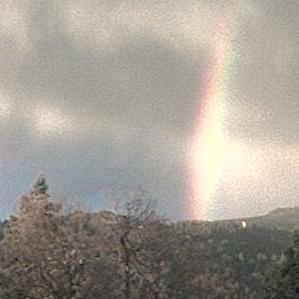

Full Image:  C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\clearfalsepositives\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg
subimage:  C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg_0.jpg
The image contains smoke - probability:  0.6468777


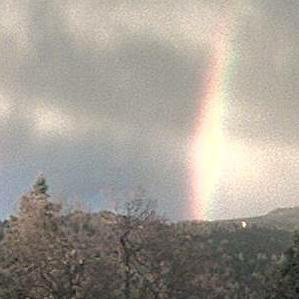

subimage:  C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg_1.jpg
The image contains smoke - probability:  0.6468777


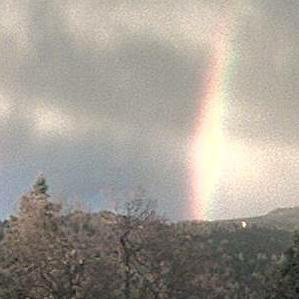

subimage:  C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg_2.jpg
The image contains smoke - probability:  0.6468777


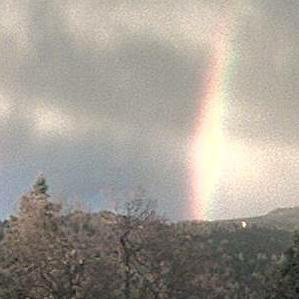

subimage:  C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages\fp_bh-e-mobo-c__2019-04-22T19_18_14_Crop_500x495x799x794 (1).jpg_3.jpg
The image contains smoke - probability:  0.6468777


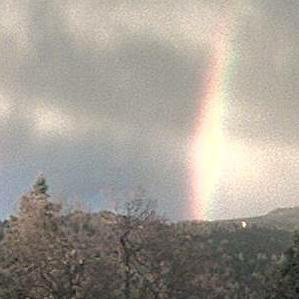

In [94]:
# Disply the original large image, pass the subimages to the model for prediction, and print out the predictions for each.
# If smoke is predicted, also display the subimage within which the smoke was detected.
displayMyImage(path_to_img)
print('Full Image: ',path_to_img)

directory = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\subimages' # cropped 299x299 subimages for the above image 
#directory = r'C:\Users\mthor\Bootcamp\Wildfire-Detection\Margaret\deerhorn'
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        name = os.path.join(directory, filename)
        prediction = getMyPrediction(name,model)
        print('subimage: ',name)
              
        if prediction > 0.5:
            print('The image contains smoke - probability: ', prediction)
            displayMyImage(name)
        else:
            if prediction <= 0.5:
                print("The image contains no smoke.")
    else:
        continue
      
